In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graph_tool.all as gt
import networkx as nx
import os
import cowsay
sns.set_theme(style="whitegrid")
pwd = os.getcwd()
my_dpi=300
colmex = pd.read_csv(pwd + "/1_colmex_limpio.csv")
red_colmex = pd.read_csv(pwd +"/2_red_colmex_completa.csv")

In [2]:
# Una función que nos da el índice en Colmex al escribir el usuario
def index_colmex(username):
    try:
        index = colmex['username'].loc[lambda x: x==username].index[0]
        print("El index en Colmex de " + username + " es " + str(index))
    except IndexError:
        print ("El usuario no está en Colmex")

# Función que nos da el usuario y ID en Colmex al escribir el índice
def username_colmex(index):
    try:
        id = colmex['id'].iloc[index]
        user = colmex['username'].iloc[index]
        print("El username en Colmex del índice " + str(index) + " es " + user + ", ID: " + str(id))
    except IndexError:
        print ("El índice no está en Colmex")
# Función que nos dice cuántos following tiene un usuario
def following(username):
    summary = red_colmex.groupby('username').agg(following=('target', 'size')).reset_index().sort_values(['following'], ascending=False)
    return summary.loc[summary['username'] == username]

In [3]:
index_colmex('humbertobeck')

El index en Colmex de humbertobeck es 140


In [4]:
username_colmex(140)

El username en Colmex del índice 140 es humbertobeck, ID: 1250382440


In [5]:
print("Usuarios de los cuales hay datos: "+ str(len(red_colmex.username.unique())))

Usuarios de los cuales hay datos: 299


## Resultados de Twitter

In [6]:
red_colmex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276364 entries, 0 to 276363
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          276364 non-null  int64 
 1   username    276364 non-null  object
 2   status      276364 non-null  object
 3   center      276364 non-null  object
 4   target      276364 non-null  int64 
 5   t_username  276364 non-null  object
 6   t_name      276353 non-null  object
dtypes: int64(2), object(5)
memory usage: 14.8+ MB


## Red interna del Colmex

In [7]:
red_colmex = red_colmex.rename(columns={'id':'source'})
red_interna = red_colmex.loc[red_colmex['t_username'].isin(colmex.username)]
red_interna

,source,username,status,center,target,t_username,t_name
30,94496757,MGF91,former,CEE,1241634845220110336,VelaDib,Abraham Vela
191,94496757,MGF91,former,CEE,107570664,diego_lopezt,Diego Tamayo
234,94496757,MGF91,former,CEE,1656204008,melinaltamirano,Melina Altamirano
265,94496757,MGF91,former,CEE,887081321352364033,b_guemez,braulio g
266,94496757,MGF91,former,CEE,260274699,elo_brun,Élodie Brun
...,...,...,...,...,...,...,...
276085,176863968,Alextuto,former,CEI,2494626685,LoaezaSoledad,Soledad Loaeza
276093,176863968,Alextuto,former,CEI,2291367079,flamand_laura,Laura Flamand
276104,176863968,Alextuto,former,CEI,118224151,elcolmex,El Colegio de México
276106,176863968,Alextuto,former,CEI,456751217,CEIColmex,CEI Colmex


In [8]:
edges_interna_nd = red_interna[['source', 'target']].reset_index(drop=True)  # Creamos no dirigida (nd)
# Tenemos ahora red pero queremos quedarnos con las relaciones de followback (no dirigidas). Por ejemplo 0,1 y 1,0 son dos personas que se siguen mutuamente, queremos quedarnos con esa relación 0,1 
edges_interna_nd.shape

(11184, 2)

In [9]:
# Que nos ordene las lineas en orden para que queden duplicadas, por ejemplo 0,1 y 1,0
sorted_cols = edges_interna_nd[['source', 'target']].apply(sorted, axis=1)
# Reemplazamos las columnas por las columnas ordenadas con el método de string
edges_interna_nd['source'] = sorted_cols.str[0]; # Ahora source son todos los menores
edges_interna_nd['target'] = sorted_cols.str[1]; # target son todos los mayores

# Nos quedamos con los duplicados (Quienes tienen Followback)
edges_interna_nd = edges_interna_nd[edges_interna_nd.duplicated()] # keep=False
# Tamaño después de dropear duplicados
edges_interna_nd.shape

(2951, 2)

In [10]:
# Prueba Followback
edges_interna_nd.loc[(edges_interna_nd['source'] == 118659352) & (edges_interna_nd['target'] == 260274699)]

,source,target
6898,118659352,260274699


In [11]:
# Prueba Followback
edges_interna_nd.loc[(edges_interna_nd['source'] == 260274699) & (edges_interna_nd['target'] == 118659352)]

,source,target


In [12]:
# Se fija en cada línea y quita todas las repetdias
# edges_interna_nd = edges_interna_nd.drop_duplicates(subset=['source', 'target']) 
# Nos quedamos con las filas que tienen valores distintos source/target
# edges_interna_nd = edges_interna_nd[edges_interna_nd['source'] != edges_interna_nd['target']] 
# Tamaño después de dropear duplicados
# edges_interna_nd.shape

In [13]:
G = nx.Graph() # Nueva gráfica con Nx
G.add_edges_from(edges_interna_nd.values) # Que se traiga edges de edgelist
G

In [14]:
print("Number of nodes/usuarios", len(G))
print("Number of edges/followbacks", len(G.edges))

Number of nodes/usuarios 246
Number of edges/followbacks 2951


In [15]:
print("Número de CC",
      nx.number_connected_components(G)) #Componente conexo
print("Tamaño en nodos",
      [len(cc) for cc in nx.connected_components(G)])

Número de CC 1
Tamaño en nodos [246]


## Degree distribution

In [16]:
degree = pd.DataFrame(G.degree, columns=['id', 'degree']).sort_values('degree', ascending=False)
degree = pd.merge(degree, colmex, how='left', on="id")
degree.head(10)

,id,degree,username,status,center
0,2291367079,107,flamand_laura,current,CEI
1,118224151,101,elcolmex,current,ADM
2,127685309,88,Pau_Bouchot,former,CEE
3,103081893,87,JesusSCarrillo,current,CEE
4,83128968,84,rojo_neon,former,CES
5,1101215930963685378,83,santana_sabine,former,CEE
6,218022095,77,juancolmeda,current,CEI
7,1250382440,74,humbertobeck,current,CEI
8,15685115,68,cabrowns,former,CEE
9,956807179,66,Sofi_Leon98,current,CEI


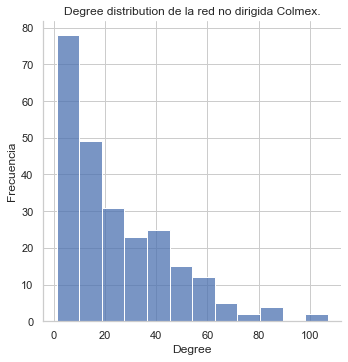

In [17]:
sns.displot(degree['degree']).set(xlabel="Degree", ylabel = "Frecuencia")
plt.title('Degree distribution de la red no dirigida Colmex.')
plt.savefig(pwd + '/figures/' + 'degree_distribution_interna_nd.png', dpi=my_dpi,bbox_inches='tight')

## Assortativity

In [18]:
nodos = degree.dropna()
nodos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        246 non-null    int64 
 1   degree    246 non-null    int64 
 2   username  246 non-null    object
 3   status    246 non-null    object
 4   center    246 non-null    object
dtypes: int64(2), object(3)
memory usage: 11.5+ KB


In [19]:
nodos['current'] = np.where(nodos['status']=='current', True, False)
for center in ['CEAA','CEDUA','CEE','CEH','CEI','CELL','CES','ADM']:
    nodos[center] = np.where(nodos['center']==center, True, False)

att_status = dict(zip(nodos['id'], nodos['status']))
att_current = dict(zip(nodos['id'], nodos['current']))

att_center = dict(zip(nodos['id'], nodos['center']))
att_CEAA = dict(zip(nodos['id'], nodos['CEAA']))
att_CEDUA = dict(zip(nodos['id'], nodos['CEDUA']))
att_CEE = dict(zip(nodos['id'], nodos['CEE']))
att_CEH = dict(zip(nodos['id'], nodos['CEH']))
att_CEI = dict(zip(nodos['id'], nodos['CEI']))
att_CELL= dict(zip(nodos['id'], nodos['CELL']))
att_CES = dict(zip(nodos['id'], nodos['CES']))
att_ADM = dict(zip(nodos['id'], nodos['ADM']))
nodos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        246 non-null    int64 
 1   degree    246 non-null    int64 
 2   username  246 non-null    object
 3   status    246 non-null    object
 4   center    246 non-null    object
 5   current   246 non-null    bool  
 6   CEAA      246 non-null    bool  
 7   CEDUA     246 non-null    bool  
 8   CEE       246 non-null    bool  
 9   CEH       246 non-null    bool  
 10  CEI       246 non-null    bool  
 11  CELL      246 non-null    bool  
 12  CES       246 non-null    bool  
 13  ADM       246 non-null    bool  
dtypes: bool(9), int64(2), object(3)
memory usage: 13.7+ KB


In [20]:
nx.set_node_attributes(G, att_status, 'status')
nx.set_node_attributes(G, att_current, 'current')
nx.set_node_attributes(G, att_center, 'center')
nx.set_node_attributes(G, att_CEAA, 'CEAA')
nx.set_node_attributes(G, att_CEDUA, 'CEDUA')
nx.set_node_attributes(G, att_CEE, 'CEE')
nx.set_node_attributes(G, att_CEH, 'CEH')
nx.set_node_attributes(G, att_CEI, 'CEI')
nx.set_node_attributes(G, att_CELL, 'CELL')
nx.set_node_attributes(G, att_CES, 'CES')
nx.set_node_attributes(G, att_ADM, 'ADM')

In [21]:
# G.nodes(data=True)

In [22]:
nx.attribute_assortativity_coefficient(G, 'status')

0.1742599504985215

In [23]:
nx.attribute_assortativity_coefficient(G, 'center')

0.2449662617996422

## Clustering

In [24]:
# Indivdual
clust = nx.clustering(G)
# Global Average clustering
print(f'Average clustering {nx.average_clustering(G)}')

Average clustering 0.4803528133551367


## Central nodes

In [25]:
# El método betweenness_centrality() nos regresa un diccionario con el betweenness de cada nodo
bet = nx.betweenness_centrality(G)
# Ordenamos los items del diccionario por una función lambda que toma el segundo elemento
# Items me regresa tuples 2 con llave y valor, nos sirve para iterar
# Podría ser lambda x: x[1], reverse=True
max_bet = sorted(bet.items(), key=lambda x: -x[1])
bet[max_bet[0][0]]
max_bet[0]

(127685309, 0.06800639928287394)

## Closenness

In [26]:
# Lo mismo pero ahora para el closeness_centrality
# Qué tan rápido podemos llegar de un nodo a todos los demás
clos = nx.closeness_centrality(G)
max_clos = sorted(clos.items(), key=lambda x: -x[1])
clos[max_clos[0][0]]
max_clos[0][1]

0.6218274111675127

## $k$-core decomposition

In [27]:
# Para nx usamos core_number y nos regresa un diccionario con personajes y el core number de c/u
core = nx.core_number(G)
max_k = max(core.values())
# List comprehension
[x for x in core if core[x]==max_k][1:10] # Nos quedamos con los nodos que están en el main-core

[818414802,
 825100500307738626,
 170398596,
 1372542209262813185,
 1117960034,
 809934481,
 127685309,
 153982881,
 587894779]

In [28]:
max_k

22

## Drawing

In [29]:
# nx.draw_networkx(G)

In [30]:
cowsay.cow(
    ' Red interna del Colmex no dirigida (followbacks).\n '
    + str(len(G)) + ' Número de nodes/usuarios.\n '
    + str(len(G.edges)) + ' Número de edges/followbacks.\n '
    + str(round(nx.attribute_assortativity_coefficient(G, 'status'),3)) + ' assortativity coefficient por status\n '
    + str(round(nx.attribute_assortativity_coefficient(G, 'center'),3)) + ' assortativity coefficient por centro\n '
    + str(round(nx.average_clustering(G),3)) + ' average clustering de la red interna Colmex\n '
    + str(max_bet[0][0]) + ' Usuario con mayor Betweenness: ' +str(round(max_bet[0][1],4)) + '\n'
    + str(max_clos[0][0]) + ' Usuario con mayor Closenness: ' +str(round(max_clos[0][1],4)) + '\n'
    + str(max_k) + ' Máximo k-core ' + '\n'
          )

  _________________________________________________
 /                                                 \
| Red interna del Colmex no dirigida (followbacks). |
| 246 Número de nodes/usuarios.                     |
| 2951 Número de edges/followbacks.                 |
| 0.174 assortativity coefficient por status        |
| 0.245 assortativity coefficient por centro        |
| 0.48 average clustering de la red interna Colmex  |
| 127685309 Usuario con mayor Betweenness: 0.068    |
| 2291367079 Usuario con mayor Closenness: 0.6218   |
| 22 Máximo k-core                                  |
 \                                                 /
                                                      \
                                                       \
                                                         ^__^                             
                                                         (oo)\_______                   
                                                         (__)\ 

In [31]:
edges = pd.merge(edges_interna_nd, colmex, how='left', left_on='source', right_on='id')
edges = pd.merge(edges, colmex, how='left', left_on='target', right_on='id',
                    suffixes=('_s', '_t'))
edges = edges.drop(['id_s', 'id_t'], axis=1)

In [32]:
edges

,source,target,username_s,status_s,center_s,username_t,status_t,center_t
0,45420967,94496757,ricardo_delao,former,CEE,MGF91,former,CEE
1,818414802,825100500307738626,Monsieur_JABS,current,CEI,Rijasso,former,CEI
2,94496757,3743966598,MGF91,former,CEE,atzinchiguil,current,CEE
3,170398596,818414802,pablo_derbez,current,CEE,Monsieur_JABS,current,CEI
4,170398596,825100500307738626,pablo_derbez,current,CEE,Rijasso,former,CEI
...,...,...,...,...,...,...,...,...
2946,176863968,188178655,Alextuto,former,CEI,cero1796,former,CEI
2947,176863968,328723102,Alextuto,former,CEI,aaaa_a_t,former,CEI
2948,36137994,176863968,Oscar__Matz,former,CEI,Alextuto,former,CEI
2949,118224151,176863968,elcolmex,current,ADM,Alextuto,former,CEI


## Guardamos la red para llevarla a graph-tool

In [33]:
print("Number of nodes/usuarios", len(G))
print("Number of edges/followbacks", len(G.edges))
nx.write_graphml(G,pwd + "/red_interna_nd.xml")

Number of nodes/usuarios 246
Number of edges/followbacks 2951


In [34]:
g = gt.load_graph(pwd + "/red_interna_nd.xml")
g

<Graph object, undirected, with 246 vertices and 2951 edges, 12 internal vertex properties, 1 internal edge property, at 0x170be8040>

In [35]:
# g.properties

In [36]:
labels = g.vertex_properties['_graphml_vertex_id']
nodes = {labels[x]: x for x in g.iter_vertices()}

In [37]:
dic_center = { 
    "CEE":0,
     "CEH":1,
     "CEI":2,
     "CEE":3,
     "CELL":4,
     "CEAA":5,
     "CEDUA":6,
     "CES":7,
     "ADM":8}
dic_center2 = { 
    "CEE":"CEE",
     "CEH":"CEH",
     "CEI":"CEI",
     "CEE":"CEE",
     "CELL":"CEL",
     "CEAA":"CEA",
     "CEDUA":"CED",
     "CES":"CES",
     "ADM":"ADM"}

In [38]:
data = []
for v in g.vertices():
    id = labels[v]
    data.append([id])
central = pd.DataFrame(data, columns=['id'])
central["id"] = central["id"].astype(str).astype(int)
central = central.merge(nodos, how='left')
central['id'] = central['id'].astype(str)
central['center_num'] = central['center']
central['center_short'] = central['center']
central=central.replace({"center_num": dic_center})
central=central.replace({"center_short": dic_center2})
central.head()

,id,degree,username,status,center,current,CEAA,CEDUA,CEE,CEH,CEI,CELL,CES,ADM,center_num,center_short
0,45420967,15,ricardo_delao,former,CEE,False,False,False,True,False,False,False,False,False,3,CEE
1,94496757,60,MGF91,former,CEE,False,False,False,True,False,False,False,False,False,3,CEE
2,818414802,62,Monsieur_JABS,current,CEI,True,False,False,False,False,True,False,False,False,2,CEI
3,825100500307738626,54,Rijasso,former,CEI,False,False,False,False,False,True,False,False,False,2,CEI
4,3743966598,7,atzinchiguil,current,CEE,True,False,False,True,False,False,False,False,False,3,CEE


In [39]:
# Recordar que la función zip nos junta elementos y los metemos en un dic
names = dict(zip(central['id'], central['username']))
status_dic = dict(zip(central['id'], central['status']))
center_dic = dict(zip(central['id'], central['center_short']))
centernum_dic = dict(zip(central['id'], central['center_num']))
current_dic = dict(zip(central['id'], central['current']))
CEAA_dic = dict(zip(central['id'], central['CEAA']))
CEDUA_dic = dict(zip(central['id'], central['CEDUA']))
CEE_dic = dict(zip(central['id'], central['CEE']))
CEH_dic = dict(zip(central['id'], central['CEH']))
CEI_dic = dict(zip(central['id'], central['CEI']))
CELL_dic = dict(zip(central['id'], central['CELL']))
CES_dic = dict(zip(central['id'], central['CES']))
ADM_dic = dict(zip(central['id'], central['ADM']))

users = g.new_vertex_property('string')
status = g.new_vertex_property('string')
center = g.new_vertex_property('string')
center_num = g.new_vertex_property('int32_t')
current = g.new_vertex_property('bool')
CEAA = g.new_vertex_property('bool')
CEDUA = g.new_vertex_property('bool')
CEE = g.new_vertex_property('bool')
CEH = g.new_vertex_property('bool')
CEI = g.new_vertex_property('bool')
CELL = g.new_vertex_property('bool')
CES = g.new_vertex_property('bool')
ADM = g.new_vertex_property('bool')

# Itero sobre las llaves de los nombres y nos traemos valores en el diccionario names
for v in names:
    users[nodes[v]] = names[v]
    status[nodes[v]] = status_dic[v]
    center[nodes[v]] = center_dic[v]
    center_num[nodes[v]] = centernum_dic[v]
    current[nodes[v]] = current_dic[v]
    CEAA[nodes[v]] = CEAA_dic[v]
    CEDUA[nodes[v]] = CEDUA_dic[v]
    CEE[nodes[v]] = CEE_dic[v]
    CEH[nodes[v]] = CEH_dic[v]
    CEI[nodes[v]] = CEI_dic[v]
    CELL[nodes[v]] = CELL_dic[v]
    CES[nodes[v]] = CES_dic[v]
    ADM[nodes[v]] = ADM_dic[v]

text_size = g.degree_property_map('out')
text_size.a = 2 * np.sqrt(text_size.a)

In [40]:
# pos = gt.sfdp_layout(g) #
pos = gt.arf_layout(g) # 1
# pos = gt.fruchterman_reingold_layout(g) # 
# pos = gt.radial_tree_layout(g,137) # nodes['118224151'] # Node @elcolmex

In [41]:
# pos = gt.arf_layout(g) 
gt.graph_draw(g,edge_color = [0.2, 0.2, 0.2, 0.2], pos=pos,output= pwd + '/figures/' + "red_interna_nd.png")
# pos = gt.sfdp_layout(g)

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170be2610>

In [42]:
# pos = gt.arf_layout(g) 
gt.graph_draw(g,edge_color = [0.2, 0.2, 0.2, 0.2], pos=pos,vertex_fill_color=current,
vertex_text=status,vertex_font_size=5,
output= pwd + '/figures/' + "red_interna_nd_current.png")
# pos = gt.sfdp_layout(g)

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170c94a30>

In [43]:
# pos = gt.arf_layout(g) 
gt.graph_draw(g,edge_color = [0.2, 0.2, 0.2, 0.2], pos=pos,vertex_fill_color=center_num,vertex_text=center,vertex_font_size=6,
output= pwd + '/figures/' + "red_interna_nd_center.png")
# pos = gt.sfdp_layout(g)

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170c94a90>

In [44]:
# pos = gt.arf_layout(g)
gt.graph_draw(g, pos=pos, vertex_text=users,vertex_fill_color=center_num,vertex_font_size=4,
edge_color = [0.2, 0.2, 0.2, 0.2],
output= pwd + '/figures/' + "red_interna_nd_center_usernames.png")
# pos = gt.sfdp_layout(g)

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170b75c40>

In [45]:
# pos = gt.arf_layout(g)
gt.graph_draw(g, pos=pos, vertex_text=users,
              vertex_font_size=text_size,edge_color = [0.2, 0.2, 0.2, 0.2],
              output= pwd + '/figures/' + "red_interna_nd_usernames_degree.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170c948e0>

In [46]:
# Para betweenness puede ser para nodos y para aristas.
# Me regresa dos property maps, uno para vertex y para edges
vb, eb = gt.betweenness(g)
# Volvemos a dibujar la red ahora utilizando el betweenness para hacer gruesos los edge y los vertex
gt.graph_draw(g, pos=pos,
              edge_pen_width=gt.prop_to_size(eb, mi=0, ma=5), # Notar que estoy normalizando con prop_to_size de 0 a 5
              vertex_size=gt.prop_to_size(vb, mi=5, ma=15),edge_color = [0.2, 0.2, 0.2, 0.2],
              vertex_fill_color=vb, # Colorea los edges de acuerdo a su vb
              output= pwd + '/figures/' + "red_interna_nd_betweenness.png") 

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170b75b20>

In [47]:
# Hacemos lo mismo para el closeness centrality
vc = gt.closeness(g)
gt.graph_draw(g, pos=pos,edge_color = [0.2, 0.2, 0.2, 0.2],
              vertex_size=gt.prop_to_size(vc, mi=5, ma=15),
              vertex_fill_color=vc,
              output= pwd + '/figures/' + "red_interna_nd_closeness.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170c8bbe0>

In [48]:
# Hacemos lo mismo para el page rank
vpr = gt.pagerank(g)
gt.graph_draw(g, pos=pos,edge_color = [0.2, 0.2, 0.2, 0.2],
              vertex_size=gt.prop_to_size(vpr, mi=5, ma=15),
              vertex_fill_color=vpr,
              output= pwd + '/figures/' + "red_interna_nd_pagerank.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170b8aaf0>

In [49]:
# Le saco el grado de los nodos y hago los nodos mas conectados más grandes
deg = g.degree_property_map('out')
gt.graph_draw(g, pos=pos,edge_color = [0.2, 0.2, 0.2, 0.2],
              vertex_size=gt.prop_to_size(deg, mi=5, ma=15),
              output= pwd + '/figures/' + "red_interna_nd_degree.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170be8c40>

In [50]:
data = []
for v in g.vertices():
    b = vb[v]
    c = vc[v]
    pr = vpr[v]
    d = deg[v]
    id = labels[v]
    data.append([id, b, c, pr, d])
central = pd.DataFrame(data, columns=['id', 'betweenness',
                                      'closenness', 'page_rank',
                                      'degree'])

central["id"] = central["id"].astype(str).astype(int)
central = central.merge(colmex, how='left')
central['id'] = central['id'].astype(str)
central.head()

,id,betweenness,closenness,page_rank,degree,username,status,center
0,45420967,0.001019,0.469349,0.002865,15,ricardo_delao,former,CEE
1,94496757,0.016973,0.551802,0.009402,60,MGF91,former,CEE
2,818414802,0.016148,0.538462,0.009152,62,Monsieur_JABS,current,CEI
3,825100500307738626,0.009724,0.528017,0.007914,54,Rijasso,former,CEI
4,3743966598,0.001029,0.408333,0.001953,7,atzinchiguil,current,CEE


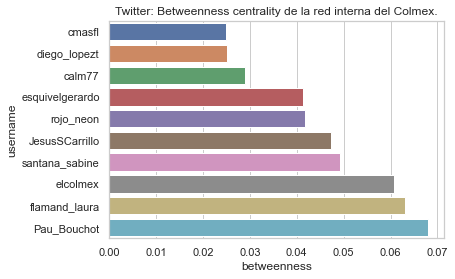

In [51]:
var = 'betweenness'
ax = sns.barplot(x=var,
            y='username',
            data=central.sort_values(var).iloc[-10:])
plt.title('Twitter: Betweenness centrality de la red interna del Colmex.')
plt.savefig(pwd + '/figures/' + 'betweenness_interna_nd.png', dpi=my_dpi,bbox_inches='tight')

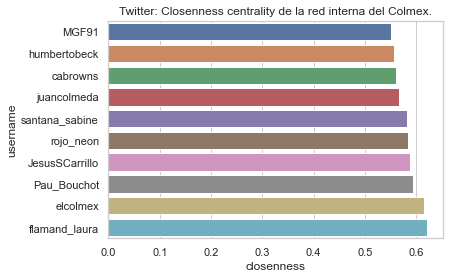

In [52]:
var = 'closenness'
ax = sns.barplot(x=var,
            y='username',
            data=central.sort_values(var).iloc[-10:])
plt.title('Twitter: Closenness centrality de la red interna del Colmex.')
plt.savefig(pwd + '/figures/' + 'closenness_interna_nd.png', dpi=my_dpi,bbox_inches='tight')

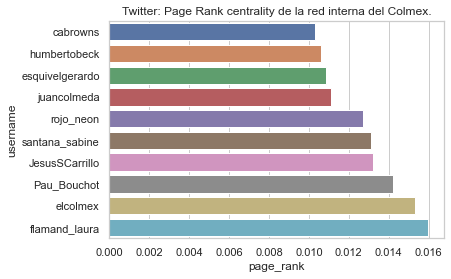

In [53]:
var = 'page_rank'
ax = sns.barplot(x=var,
            y='username',
            data=central.sort_values(var).iloc[-10:])
plt.title('Twitter: Page Rank centrality de la red interna del Colmex.')
plt.savefig(pwd + '/figures/' + 'pagerank_interna_nd.png', dpi=my_dpi,bbox_inches='tight')

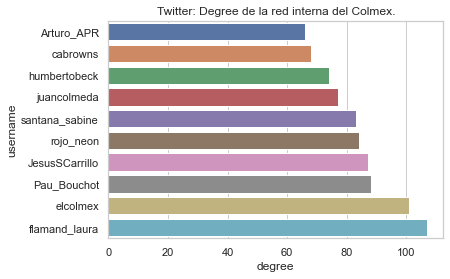

In [54]:
var = 'degree'
ax = sns.barplot(x=var,
            y='username',
            data=central.sort_values(var).iloc[-10:])
plt.title('Twitter: Degree de la red interna del Colmex.')
plt.savefig(pwd + '/figures/' + 'degree_interna_nd.png', dpi=my_dpi,bbox_inches='tight')

<AxesSubplot:xlabel='degree', ylabel='frequency'>

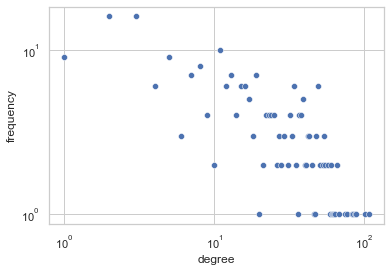

In [55]:
freq = central.groupby('degree').size().reset_index(name='frequency')
# freq
fig = plt.figure()
ax = fig.add_subplot()
ax.set(xscale="log", yscale="log")
# Plot using `sns.scatterplot` in axes `ax`
sns.scatterplot(data=freq, x='degree', y='frequency', ax=ax)

## $k$-core decomposition

A $k$-core is a maximal subgraph that contains nodes of degree k or more.  

In [56]:
core = gt.kcore_decomposition(g)
clos = gt.closeness(g)

In [57]:
gt.graph_draw(g, pos=pos, vertex_fill_color=core, vertex_text=core, edge_color = [0.2, 0.2, 0.2, 0.2],
              # vertex_size=gt.prop_to_size(clos, mi=2, ma=25),
              vertex_font_size=11, output= pwd + '/figures/' + "red_interna_nd_kcore.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x171199c10>

## Minimize Blockmodel

In [58]:
state = gt.minimize_blockmodel_dl(g)
state

<BlockState object with 11 blocks (11 nonempty), degree-corrected, for graph <Graph object, undirected, with 246 vertices and 2951 edges, 12 internal vertex properties, 1 internal edge property, at 0x170be8040>, at 0x1711d5e80>

In [59]:
b = state.get_blocks()

In [60]:
blocks = []
nodes = []
for v in g.iter_vertices():
    blocks.append(b[v])
    nodes.append(labels[v])
df_block = pd.DataFrame({'id': nodes, 'block': blocks})
central = central.merge(df_block, how='left')
central

,id,betweenness,closenness,page_rank,degree,username,status,center,block
0,45420967,0.001019,0.469349,0.002865,15,ricardo_delao,former,CEE,0
1,94496757,0.016973,0.551802,0.009402,60,MGF91,former,CEE,1
2,818414802,0.016148,0.538462,0.009152,62,Monsieur_JABS,current,CEI,2
3,825100500307738626,0.009724,0.528017,0.007914,54,Rijasso,former,CEI,2
4,3743966598,0.001029,0.408333,0.001953,7,atzinchiguil,current,CEE,0
...,...,...,...,...,...,...,...,...,...
241,3191354686,0.009350,0.530303,0.007606,51,secolmex,current,ADM,9
242,2494626685,0.000378,0.425347,0.002296,12,LoaezaSoledad,current,CEI,10
243,437200769,0.000003,0.364583,0.000871,2,ommyareizaga,current,CEDUA,1
244,435299501,0.001352,0.447080,0.002601,13,DeniseDresserG,former,CEI,1


In [61]:
gt.graph_draw(g, pos=pos, vertex_text=b, vertex_fill_color='white',
edge_color = [0.2, 0.2, 0.2, 0.2], vertex_font_size=12,
              output= pwd + '/figures/' + "red_interna_nd_minimizeblock.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x170ebdd00>

In [62]:
# central[central['block']==3]

,id,betweenness,closenness,page_rank,degree,username,status,center,block
5,170398596,0.003376,0.472062,0.005525,35,pablo_derbez,current,CEE,3
6,1372542209262813185,0.001384,0.460526,0.004964,33,__miirrrr,former,CEE,3
12,2885499000,0.000000,0.376344,0.001102,3,luis__fer__,current,CEE,3
19,872981619220545536,0.000894,0.470250,0.004115,27,BMOG00,current,CEI,3
20,887641962,0.000960,0.471154,0.004263,28,_Mar1508,current,CEI,3
22,523830221,0.000035,0.414552,0.001808,9,_diegoac,former,CEE,3
24,1202734710,0.000031,0.373476,0.001334,5,rodrigo_charvel,current,CEI,3
26,1721825347,0.000500,0.453704,0.003577,23,xilngocentrista,current,CEI,3
39,1096180073504428032,0.000825,0.426829,0.003297,19,MarianoT306,current,CEE,3
40,2455365890,0.000037,0.382812,0.001286,5,MesiKhaleesi,current,CEDUA,3


In [64]:
summary_central = central.groupby(['block','center']) \
       .agg(usuarios=('id','nunique')) \
       .reset_index().sort_values(['block'], ascending=True) 

In [66]:
summary_central

,block,center,usuarios
0,0,CEDUA,9
1,0,CEE,28
2,0,CEI,1
3,0,CELL,2
4,1,ADM,2
5,1,CEDUA,11
6,1,CEE,9
7,1,CEH,4
8,1,CEI,6
9,1,CELL,1


In [65]:
summary_central['block'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [67]:
summary_central
summary_central.to_csv (pwd + "/5_comunidades.csv", index = False)

## Redes filtradas

current	CEAA	CEDUA	CEE	CEH	CEI	CELL	CES	ADM

In [68]:
g.set_vertex_filter(CEAA)
gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
                vertex_fill_color = [0.5, 0.5, 0.5, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2],
                output= pwd + '/figures/' + "red_interna_nd_CEAA.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x1711ed160>

In [69]:
g.set_vertex_filter(CEDUA)
gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
                vertex_fill_color = [0.2, 0.5, 0.2, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2],
                output= pwd + '/figures/' + "red_interna_nd_CEDUA.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x171236b80>

In [70]:
g.set_vertex_filter(CEE)
gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
                vertex_fill_color = [0.6, 0.2, 0.1, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2],
                output= pwd + '/figures/' + "red_interna_nd_CEE.png")                

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x1712368e0>

In [71]:
g.set_vertex_filter(CEH)
gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
                vertex_fill_color = [0.5, 0.5, 0.7, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2],
                output= pwd + '/figures/' + "red_interna_nd_CEH.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x171236d60>

In [72]:
g.set_vertex_filter(CEI)
gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
                vertex_fill_color = [0.1, 0.2, 0.4, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2],
                output= pwd + '/figures/' + "red_interna_nd_CEI.png")             

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x1711ed100>

In [73]:
g.set_vertex_filter(CELL)
gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
                vertex_fill_color = [0.7, 0.5, 0.7, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2],
                output= pwd + '/figures/' + "red_interna_nd_CELL.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x171236ac0>

In [74]:
g.set_vertex_filter(CES)
gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
                vertex_fill_color = [0.5, 0.2, 0.2, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2],
                output= pwd + '/figures/' + "red_interna_nd_CES.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x1711eda60>

In [75]:
g.set_vertex_filter(ADM)
gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
                vertex_fill_color = [0.6, 0.5, 0.4, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2],
                output= pwd + '/figures/' + "red_interna_nd_ADM.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170be8040, at 0x1711eda30>

In [76]:
g.set_vertex_filter(None)
#gt.graph_draw(g, pos=pos, vertex_text=users, vertex_font_size=text_size,
#                vertex_fill_color = [0.5, 0.5, 0.5, 0.7],edge_color = [0.2, 0.2, 0.2, 0.2])